# Example 2: Cytotoxicity Contact Analysis

In this notebook we will demonstrate:
1. Convert segmented label data to sparse Pandas table
2. Use the label and sparse position table to return contact analysis across multiple frames
3. Remapping the cell feature table to ultrack results

In [1]:
from cyto.postprocessing.graph import *
from cyto.utils.label_to_table import *
import dask_image.imread
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np
import pyclesperanto_prototype as cle
from skimage import exposure
import pandas as pd


## Load image files
pyCyto supports any image loader compatible with numpy/dask. Bioimages may storage in multiple formats and dimension orders. Here we load list of single image files under same directory with Dask Image, utilizing the lazy loading function to facilitate the pipeline optimization. For large dataset dask array is more preferable than numpy for better memory managements.

In [2]:
# CANCER_IMAGE_PATH_PATTERN = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh/register_denoising/ch0/*.tif"
# TCELL_IMAGE_PATH_PATTERN = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh/register_denoising/ch2/*.tif"

# CANCER_LABEL_PATH_PATTERN = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/register_denoising_gamma_channel_merged_masks/cancer/*.tif"
# TCELL_LABEL_PATH_PATTERN = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/raw_gamma_channel_merged_masks/tcell/*.tif"

CANCER_IMAGE_PATH_PATTERN = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/register_denosing_cropped/ch0_batch5/*.tif"
TCELL_IMAGE_PATH_PATTERN = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/register_denosing_cropped/ch2_batch5/*.tif"

CANCER_LABEL_PATH_PATTERN = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/register_denoising_gamma_channel_merged_masks_cropped/cancer_batch5/*.tif"
TCELL_LABEL_PATH_PATTERN = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/raw_gamma_channel_merged_masks_cropped/tcell_batch5/*.tif"

In [3]:
# default chunk size: 1 image
image_cancer = dask_image.imread.imread(CANCER_IMAGE_PATH_PATTERN)
image_tcell = dask_image.imread.imread(TCELL_IMAGE_PATH_PATTERN)

label_cancer = dask_image.imread.imread(CANCER_LABEL_PATH_PATTERN)
label_tcell = dask_image.imread.imread(TCELL_LABEL_PATH_PATTERN)

image_cancer

dask.array<_map_read_frame, shape=(8629, 1000, 1000), dtype=uint16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>

Have a first glance of the images

In [4]:
FRAME = 100 # select the frame to perform contact analysis

Text(0.5, 1.0, 'T Cell Labels')

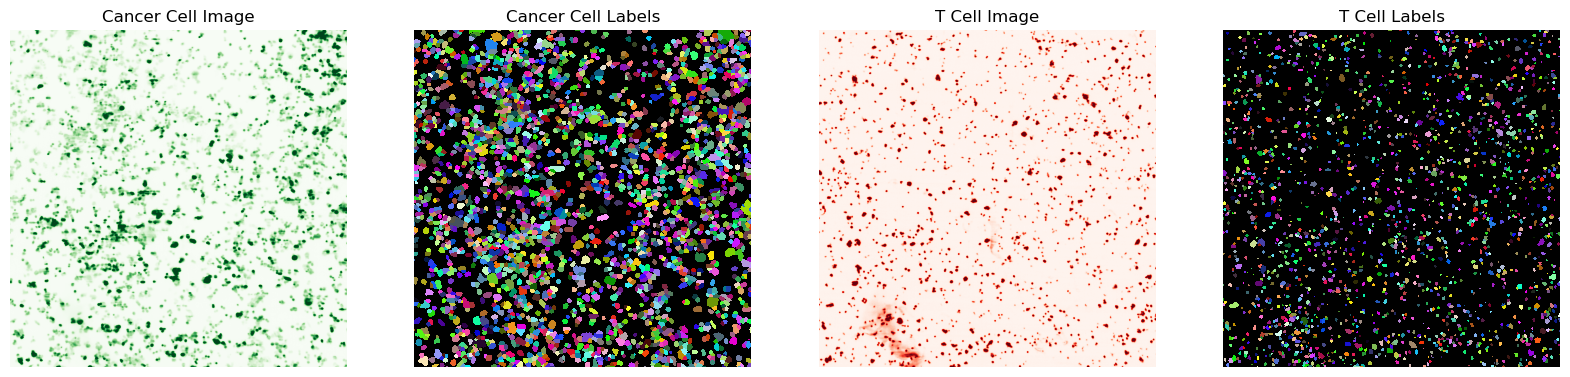

In [5]:
fig, axs = plt.subplots(1,4,figsize=(20,5))

tail=2
pl, pu = np.percentile(image_cancer[FRAME,:,:].T.ravel(), (tail, 100-tail))
axs[0].imshow(exposure.rescale_intensity(image_cancer[FRAME,:,:], in_range=(pl.compute(), pu.compute()),out_range=(0,255)),cmap="Greens")
axs[0].set_axis_off()
axs[0].set_title("Cancer Cell Image")

cle.imshow(label_cancer[FRAME,:,:], labels=True, plot=axs[1])
axs[1].set_axis_off()
axs[1].set_title("Cancer Cell Labels")

pl, pu = np.percentile(image_tcell[FRAME,:,:].T.ravel(), (tail, 100-tail))
axs[2].imshow(exposure.rescale_intensity(image_tcell[FRAME,:,:], in_range=(pl.compute(), pu.compute()),out_range=(0,255)),cmap="Reds")
axs[2].set_axis_off()
axs[2].set_title("T Cell Image")

cle.imshow(label_tcell[FRAME,:,:], labels=True, plot=axs[3])
axs[3].set_axis_off()
axs[3].set_title("T Cell Labels")

## 1. Convert Dense Cell Masks to Sparse Pandas Table

In [6]:
# convert segmentation mask to trackpy style array
features = {}

# note that pyCyto works in XYT dim order but dask/tiff is in TYX, need to transpose the array
# TODO: pixel spacing
features["cancer"] = label_to_sparse(label=label_cancer[FRAME:FRAME+1,:,:].T,image=image_cancer[FRAME:FRAME+1,:,:].T,spacing=[1,1],channel_name="cancer")
features["tcell"] = label_to_sparse(label=label_tcell[FRAME:FRAME+1,:,:].T,image=image_tcell[FRAME:FRAME+1,:,:].T,spacing=[1,1],channel_name="tcell")

Label to sparse [tcell]: 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


In [7]:
features["cancer"]

label           y           x  bbox_xstart  bbox_ystart  bbox_xsize  \
0         1  927.251656   13.530747            0          901          36   
1         2  986.469762  526.830454          502          968          47   
2         3  227.634279   42.618996           26          210          35   
3         4  884.996571  806.728000          793          869          32   
4         5  233.157960  737.358209          722          216          32   
...     ...         ...         ...          ...          ...         ...   
2564   2565  999.000000  397.000000          396          999           3   
2565   2566  999.000000  840.000000          839          999           3   
2566   2567  363.000000  999.000000          999          362           1   
2567   2568    0.000000  426.500000          426            0           2   
2568   2569  861.000000    0.000000            0          861           1   

      bbox_ysize           i           j  bbox_istart  ...  feret_diameter  \
0             48   13.530747  927.251656          0.0  ...       52.839379   
1             32  526.830454  986.469762        502.0  ...       46.097722   
2             38   42.618996  227.634279         26.0  ...       39.446166   
3             35  806.728000  884.996571        793.0  ...       39.115214   
4             34  737.358209  233.157960        722.0  ...       38.418745   
...          ...         ...         ...          ...  ...             ...   
2564           1  397.000000  999.000000        396.0  ...        2.000000   
2565           1  840.000000  999.000000        839.0  ...        2.000000   
2566           3  999.000000  363.000000        999.0  ...        2.000000   
2567           1  426.500000    0.000000        426.0  ...        1.000000   
2568           1    0.000000  861.000000          0.0  ...        0.000000   

      feret_radius   perimeter       mass         mean       median  \
0        26.419690  143.303290  8800356.0  8325.786187  3560.144531   
1        23.048861  142.652645  1744754.0  1884.183585  1771.699219   
2        19.723083  122.676020  2384779.0  2603.470524  1260.714844   
3        19.557607  113.616033  2034399.0  2325.027429  2027.191406   
4        19.209373  109.498472   531534.0   661.111940   749.730469   
...            ...         ...        ...          ...          ...   
2564      1.000000    6.473755      955.0   318.333333   238.746094   
2565      1.000000    6.473755      560.0   186.666667   238.746094   
2566      1.000000    6.473755     1322.0   440.666667   494.238281   
2567      0.500000    4.577636     2793.0  1396.500000  1516.207031   
2568      0.000000    2.681517      899.0   899.000000  1005.222656   

                sd  frame  channel  alive  
0     13665.862132      0   cancer    NaN  
1      1207.565223      0   cancer    NaN  
2      3104.307431      0   cancer    NaN  
3      1609.800594      0   cancer    NaN  
4       280.783351      0   cancer    NaN  
...            ...    ...      ...    ...  
2564     59.802453      0   cancer    NaN  
2565      4.041452      0   cancer    NaN  
2566     17.039171      0   cancer    NaN  
2567     60.104076      0   cancer    NaN  
2568      0.000000      0   cancer    NaN  

[2569 rows x 27 columns]

In [8]:
features["tcell"]

label           y           x  bbox_xstart  bbox_ystart  bbox_xsize  \
0         1  104.401084  146.029810          133           96          26   
1         2   32.806180  816.480337          806           19          19   
2         3  562.640580  934.205797          923          552          22   
3         4  702.398256  199.034884          186          692          25   
4         5   90.112760  633.952522          622           81          24   
...     ...         ...         ...          ...          ...         ...   
1882   1883  473.000000  999.000000          999          471           1   
1883   1884  348.500000    0.000000            0          347           1   
1884   1885    0.000000  843.500000          842            0           4   
1885   1886  879.000000    0.000000            0          878           1   
1886   1887    0.000000  139.000000          139            0           1   

      bbox_ysize           i           j  bbox_istart  ...  feret_diameter  \
0             19  146.029810  104.401084        133.0  ...       27.313001   
1             27  816.480337   32.806180        806.0  ...       26.925824   
2             23  934.205797  562.640580        923.0  ...       28.319605   
3             23  199.034884  702.398256        186.0  ...       26.925824   
4             19  633.952522   90.112760        622.0  ...       24.596748   
...          ...         ...         ...          ...  ...             ...   
1882           5  999.000000  473.000000        999.0  ...        4.000000   
1883           4    0.000000  348.500000          0.0  ...        3.000000   
1884           1  843.500000    0.000000        842.0  ...        3.000000   
1885           3    0.000000  879.000000          0.0  ...        2.000000   
1886           1  139.000000    0.000000        139.0  ...        0.000000   

      feret_radius  perimeter       mass         mean  median           sd  \
0        13.656500  78.240419   707362.0  1916.970190  1312.0  1708.249163   
1        13.462912  76.018977   377359.0  1059.997191   826.0   868.713254   
2        14.159802  73.892820   615879.0  1785.156522   826.0  2105.124412   
3        13.462912  78.700494   374562.0  1088.843023   664.0   962.565528   
4        12.298374  69.315185  1282133.0  3804.548961  1798.0  4960.360598   
...            ...        ...        ...          ...     ...          ...   
1882      2.000000  10.265993      808.0   161.600000   178.0     5.856620   
1883      1.500000   8.369874      521.0   130.250000   178.0     4.112988   
1884      1.500000   8.369874      550.0   137.500000   178.0    10.908712   
1885      1.000000   6.473755      391.0   130.333333   178.0     4.509250   
1886      0.000000   2.681517      146.0   146.000000   178.0     0.000000   

      frame  channel  alive  
0         0    tcell    NaN  
1         0    tcell    NaN  
2         0    tcell    NaN  
3         0    tcell    NaN  
4         0    tcell    NaN  
...     ...      ...    ...  
1882      0    tcell    NaN  
1883      0    tcell    NaN  
1884      0    tcell    NaN  
1885      0    tcell    NaN  
1886      0    tcell    NaN  

[1887 rows x 27 columns]

## 2. Contact Analysis and Add Contact Tracing to the Result Table

In [78]:
# Prepare data for pyCyto processing, beware of order of data input, here we calculate the T Cell to Cancer Cell contact
data = {}
data["images"] = [image_tcell[FRAME:FRAME+1,:,:].T,image_cancer[FRAME:FRAME+1,:,:].T]
data["labels"] = [label_tcell[FRAME:FRAME+1,:,:].T,label_cancer[FRAME:FRAME+1,:,:].T]
data["features"] = [features["tcell"], features["cancer"]]

In [80]:
# generate distance matrix
distance_matrix = cle.generate_distance_matrix(features["tcell"][['x','y']].to_numpy().T, features["cancer"][['x','y']].to_numpy().T)

In [81]:
relabelFilter = sitk.RelabelComponentImageFilter()
label_sitk_0 = relabelFilter.Execute(sitk.GetImageFromArray(data["labels"][0]))
label_0 = sitk.GetArrayFromImage(label_sitk_0)

label_sitk_1 = relabelFilter.Execute(sitk.GetImageFromArray(data["labels"][1]))
label_1 = sitk.GetArrayFromImage(label_sitk_1)
overlap_matrix = cle.generate_binary_overlap_matrix(label_0, label_1)

4 warnings generated.


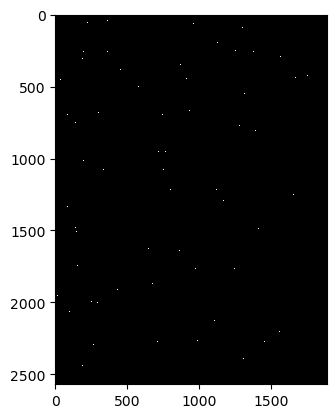

In [82]:
cle.imshow(overlap_matrix)

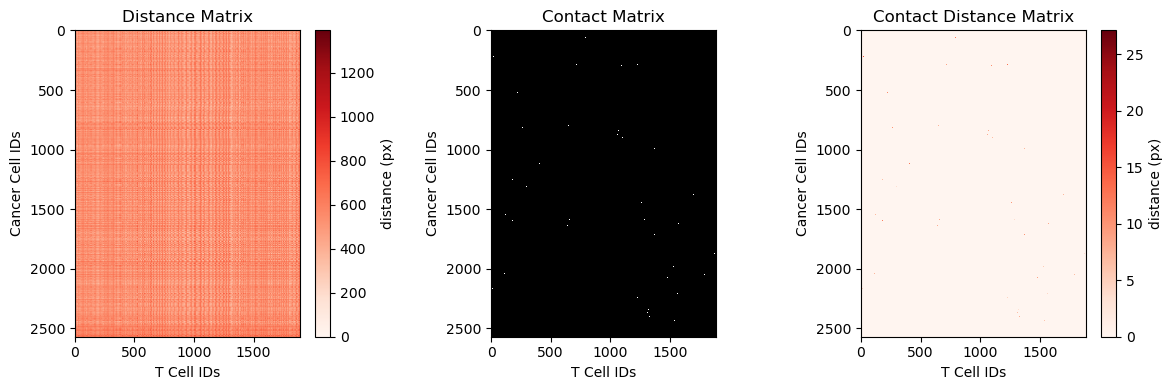

In [83]:
fig, axs = plt.subplots(1,3,figsize=(12,4))
im = axs[0].imshow(distance_matrix,cmap="Reds")
axs[0].set_xlabel("T Cell IDs")
axs[0].set_ylabel("Cancer Cell IDs")
axs[0].set_title("Distance Matrix")
cbar = plt.colorbar(im, ax=axs[0])
cbar.ax.set_ylabel('distance (px)', rotation=90)

axs[1].set_xlabel("T Cell IDs")
axs[1].set_ylabel("Cancer Cell IDs")
axs[1].set_title("Contact Matrix")
cle.imshow(overlap_matrix,plot=axs[1])

cd_matrix = cle.multiply_images(distance_matrix,overlap_matrix)
cd_matrix_host = cle.pull(cd_matrix)
im = axs[2].imshow(cd_matrix_host,cmap="Reds")
axs[2].clear()
axs[2].set_xlabel("T Cell IDs")
axs[2].set_ylabel("Cancer Cell IDs")
axs[2].set_title("Contact Distance Matrix")
cle.imshow(cd_matrix,plot=axs[2],colormap="Reds")
cbar = plt.colorbar(im, ax=axs[2])
cbar.ax.set_ylabel('distance (px)', rotation=90)

plt.tight_layout()

In [84]:
# Cross cell contact measurementsSimple plot of the contact time with the contact table output
cccm = CrossCellContactMeasures()
res = cccm(data)

Cross cell contact measurements (single): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


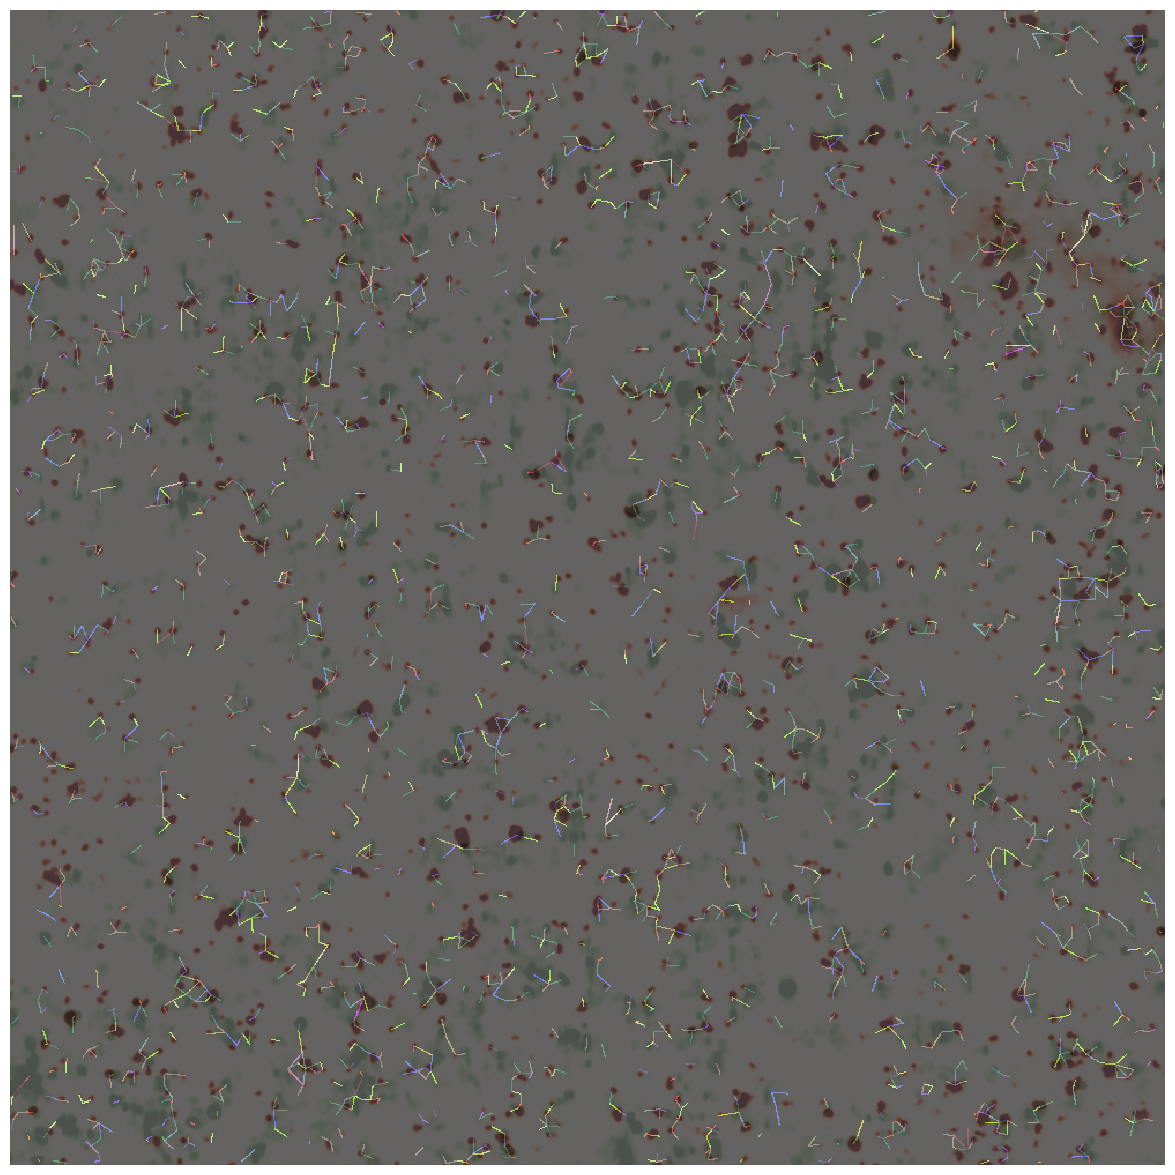

In [96]:
network_image = res["image"]

fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_axis_off()
tail = 2
pl, pu = np.percentile(image_cancer[FRAME,:,:].T.ravel(), (tail, 100-tail))

image_cancer_rescaled = exposure.rescale_intensity(image_cancer[FRAME,:,:].T, in_range=(pl.compute(), pu.compute()),out_range=(0,255))
ax.imshow(exposure.rescale_intensity(image_cancer[0,:,:].T, in_range=(pl.compute(), pu.compute()),out_range=(0,255)),cmap='Greens',alpha=0.5)
pl, pu = np.percentile(image_tcell[FRAME,:,:].T.ravel(), (tail, 100-tail))
image_tcell_rescaled = exposure.rescale_intensity(image_tcell[FRAME,:,:].T, in_range=(pl.compute(), pu.compute()),out_range=(0,255))
ax.imshow(exposure.rescale_intensity(image_tcell[0,:,:].T, in_range=(pl.compute(), pu.compute()),out_range=(0,255)),cmap='Reds',alpha=0.5)
cle.imshow(network_image[:,:,0], labels=True, plot=ax, alpha=0.6)

In [97]:
# get the cell features
features["tcell"] = res["feature"]
features["tcell"]

label           y           x  bbox_xstart  bbox_ystart  bbox_xsize  \
0         1  104.401084  146.029810          133           96          26   
1         2   32.806180  816.480337          806           19          19   
2         3  562.640580  934.205797          923          552          22   
3         4  702.398256  199.034884          186          692          25   
4         5   90.112760  633.952522          622           81          24   
...     ...         ...         ...          ...          ...         ...   
1882   1883  473.000000  999.000000          999          471           1   
1883   1884  348.500000    0.000000            0          347           1   
1884   1885    0.000000  843.500000          842            0           4   
1885   1886  879.000000    0.000000            0          878           1   
1886   1887    0.000000  139.000000          139            0           1   

      bbox_ysize           i           j  bbox_istart  ...       mass  \
0             19  146.029810  104.401084        133.0  ...   707362.0   
1             27  816.480337   32.806180        806.0  ...   377359.0   
2             23  934.205797  562.640580        923.0  ...   615879.0   
3             23  199.034884  702.398256        186.0  ...   374562.0   
4             19  633.952522   90.112760        622.0  ...  1282133.0   
...          ...         ...         ...          ...  ...        ...   
1882           5  999.000000  473.000000        999.0  ...      808.0   
1883           4    0.000000  348.500000          0.0  ...      521.0   
1884           1  843.500000    0.000000        842.0  ...      550.0   
1885           3    0.000000  879.000000          0.0  ...      391.0   
1886           1  139.000000    0.000000        139.0  ...      146.0   

             mean  median           sd  frame  channel  alive  contact  \
0     1916.970190  1312.0  1708.249163      0    tcell    NaN     True   
1     1059.997191   826.0   868.713254      0    tcell    NaN     True   
2     1785.156522   826.0  2105.124412      0    tcell    NaN     True   
3     1088.843023   664.0   962.565528      0    tcell    NaN     True   
4     3804.548961  1798.0  4960.360598      0    tcell    NaN     True   
...           ...     ...          ...    ...      ...    ...      ...   
1882   161.600000   178.0     5.856620      0    tcell    NaN    False   
1883   130.250000   178.0     4.112988      0    tcell    NaN    False   
1884   137.500000   178.0    10.908712      0    tcell    NaN    False   
1885   130.333333   178.0     4.509250      0    tcell    NaN     True   
1886   146.000000   178.0     0.000000      0    tcell    NaN    False   

             contacting cell labels  closest cell dist  
0                 [596, 1399, 1552]          11.013625  
1                  [77, 1357, 1854]           0.543120  
2                  [179, 658, 1616]          13.378088  
3                              [40]          13.643036  
4     [688, 1424, 1495, 2321, 2389]           6.275923  
...                             ...                ...  
1882                             []          23.696102  
1883                             []          13.764159  
1884                             []          21.510960  
1885                          [130]          10.334577  
1886                             []          13.966279  

[1887 rows x 30 columns]

The last three columns `contact`, `contacting cell labels` and `closest cells dist` are the corresponding contacting cancer cells.

Currently we only provide the nearest contacted cell but not the averaged one. The list of `contacting cell labels` are the corresponding label number in `features["cancer"]`

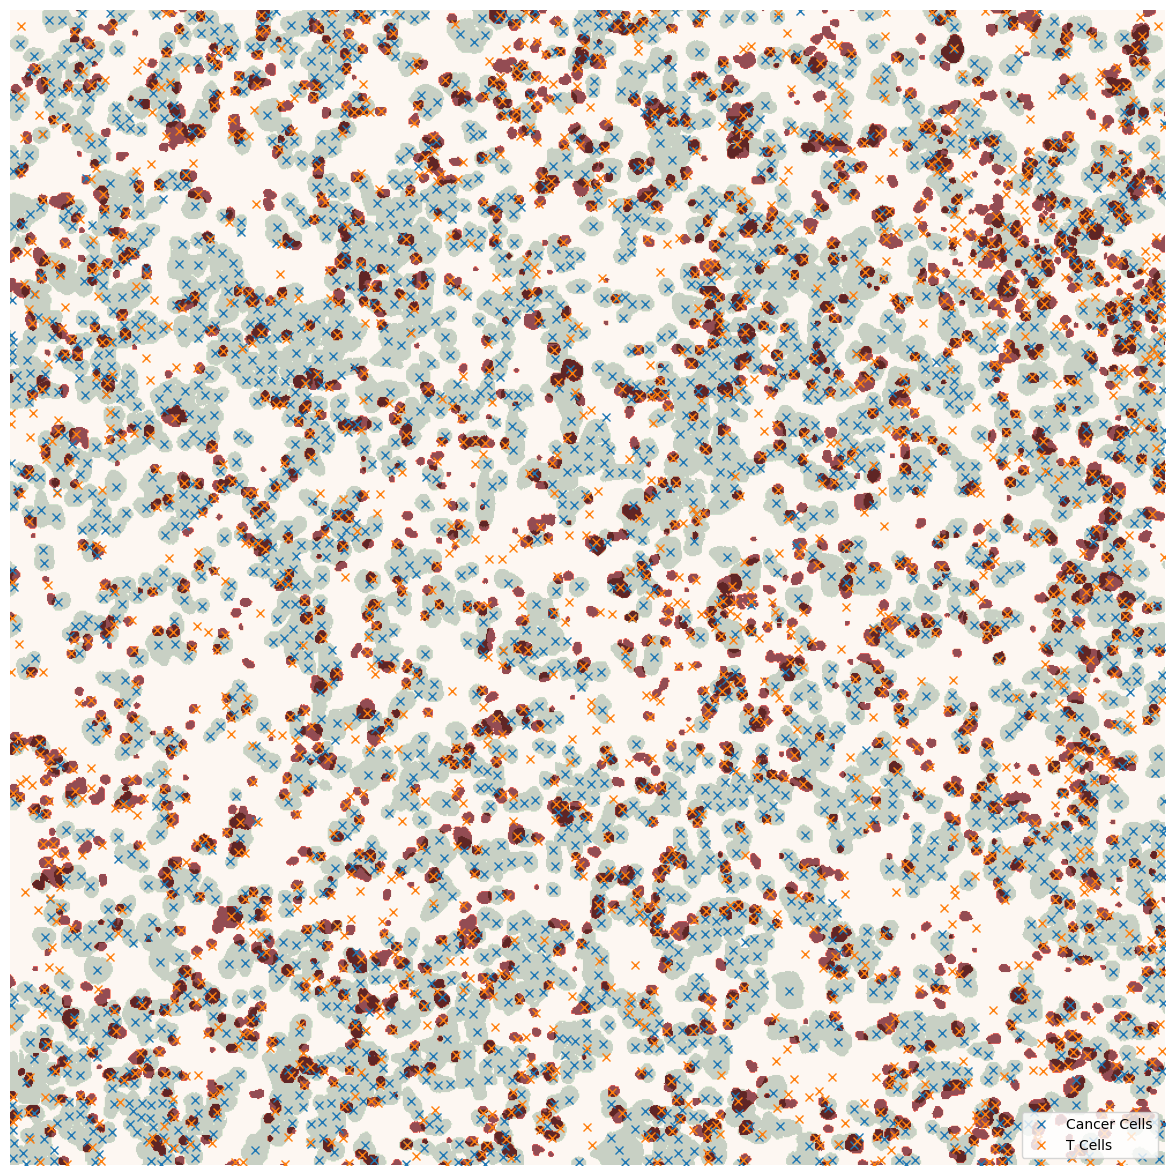

In [99]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
ax.set_axis_off()
tail = 1
frame = label_cancer[0,:,:].T
ax.imshow(exposure.rescale_intensity(frame, in_range=(0,1),out_range=(0,255)),cmap='Greens',alpha=0.7)
ax.plot(features["cancer"][features["cancer"].frame==0].i,features["cancer"][features["cancer"].frame==0].j,"x",label="Cancer Cells")
frame = label_tcell[0,:,:].T
ax.imshow(exposure.rescale_intensity(frame, in_range=(0,1),out_range=(0,255)),cmap='Reds',alpha=0.7)
ax.plot(features["tcell"][features["tcell"].frame==0].i,features["tcell"][features["tcell"].frame==0].j,"x",label="T Cells")

ax.legend(loc="lower right")

To illustrate the application of `contacting cell labels` column, we will need a cross feature table operation:

908.0 27.0 13.0 18.0
901.0 33.0 10.0 13.0


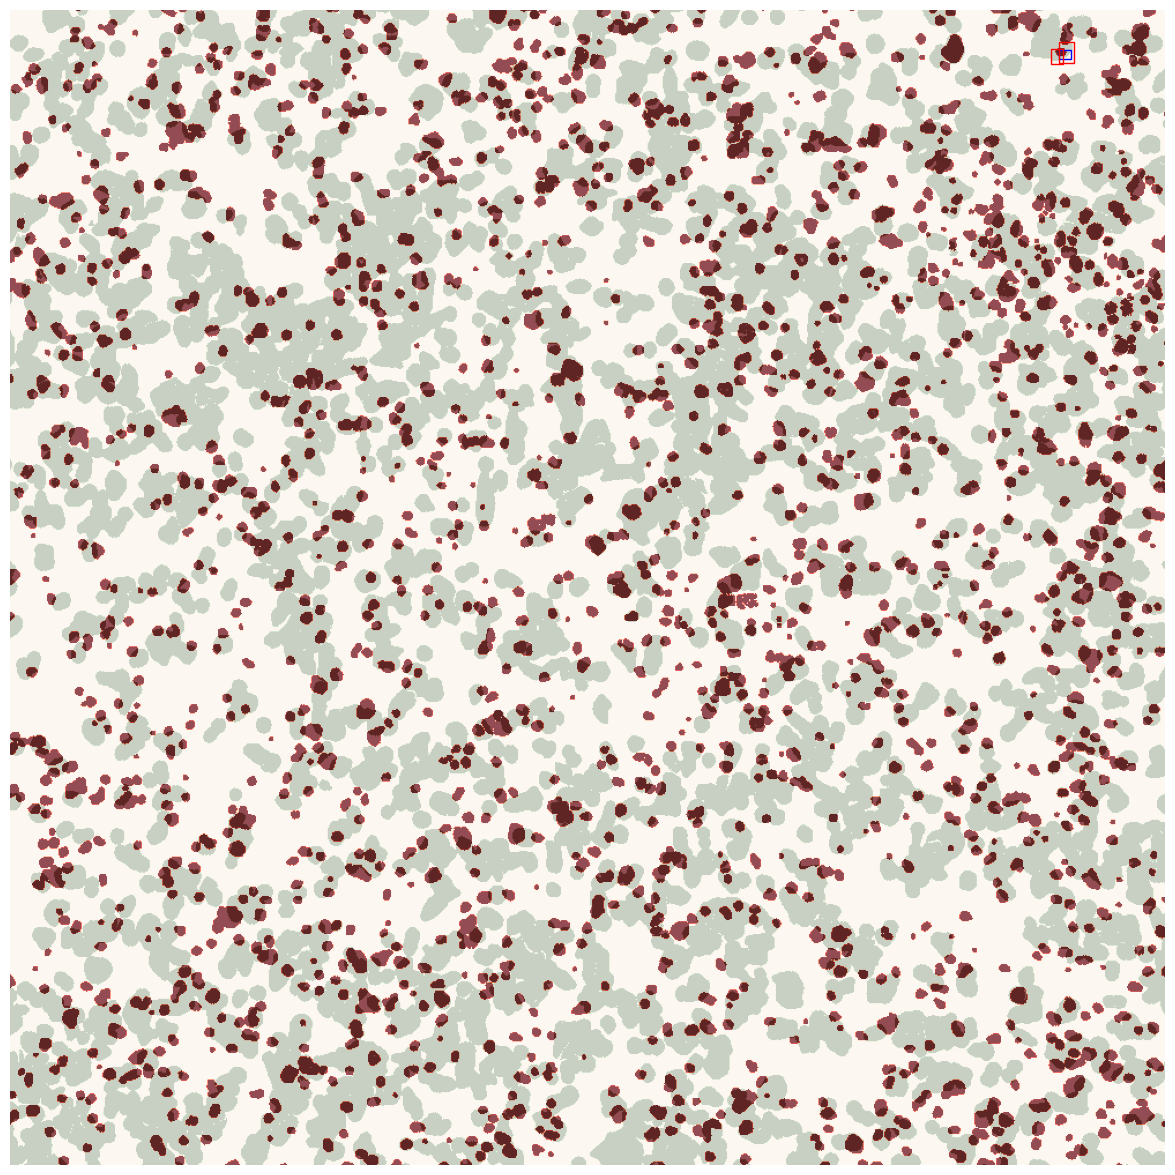

In [102]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
ax.set_axis_off()
frame = label_cancer[0,:,:].T
ax.imshow(exposure.rescale_intensity(frame, in_range=(0,1),out_range=(0,255)),cmap='Greens',alpha=0.7)
frame = label_tcell[0,:,:].T
ax.imshow(exposure.rescale_intensity(frame, in_range=(0,1),out_range=(0,255)),cmap='Reds',alpha=0.7)

# Create a Rectangle patch
TCELL_LABEL_ID = 1000

rect = patches.Rectangle((features["tcell"].bbox_istart.iloc[TCELL_LABEL_ID], features["tcell"].bbox_jstart.iloc[TCELL_LABEL_ID]), features["tcell"].bbox_isize.iloc[TCELL_LABEL_ID], features["tcell"].bbox_jsize.iloc[TCELL_LABEL_ID], linewidth=1, edgecolor='b', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

f_1 = features["cancer"][features["cancer"].frame==0]

# Create a Rectangle patch
ids = res["feature"]["contacting cell labels"].iloc[TCELL_LABEL_ID]

for id in ids:
    id -= 1 # take care of label and pandas id column
    print(f_1.bbox_istart.iloc[id], f_1.bbox_jstart.iloc[id], f_1.bbox_isize.iloc[id], f_1.bbox_jsize.iloc[id])
    rect = patches.Rectangle((f_1.bbox_istart.iloc[id], f_1.bbox_jstart.iloc[id]), f_1.bbox_isize.iloc[id], f_1.bbox_jsize.iloc[id], linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

## 3. Contact Time Plotting

Regardless of the cell size and cluster formations, here we demonstrate how to purify the cell contact analysis table and generate relevant plots.

Here we load the original track file generated by ultrack 

In [116]:
# Load tracking file and merge with the contact analysis table
TRACK_PATH = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/tracks/20231124_roi-5_0-8639_binT-1_tcell/tracks.csv"

tracks_df = pd.read_csv(TRACK_PATH)
tracks_df = tracks_df.sort_values(by=["t"])
tracks_df = tracks_df[tracks_df["t"] <= FRAME]
tracks_df

track_id    t      y      x         id  parent_track_id  parent_id
782921        6762    0    4.0  210.0    1000007               -1         -1
1177977       8957    0  212.0  435.0    1002280               -1         -1
1873167      12510    0  603.0  182.0    1006711               -1         -1
1872762      12509    0  612.0  278.0    1006701               -1         -1
1178201       8960    0  219.0  429.0    1002281               -1         -1
...            ...  ...    ...    ...        ...              ...        ...
949399        7826  100  106.0  553.0  101001154               -1  100001185
1446589      10346  100  339.0  399.0  101003773               -1  100003761
12557719     97904  100  996.0  282.0  101011952               -1  100011948
810215        7018  100   48.0  755.0  101000436               -1  100000444
975053        7948  100  129.0  901.0  101001330               -1  100001359

[205167 rows x 7 columns]

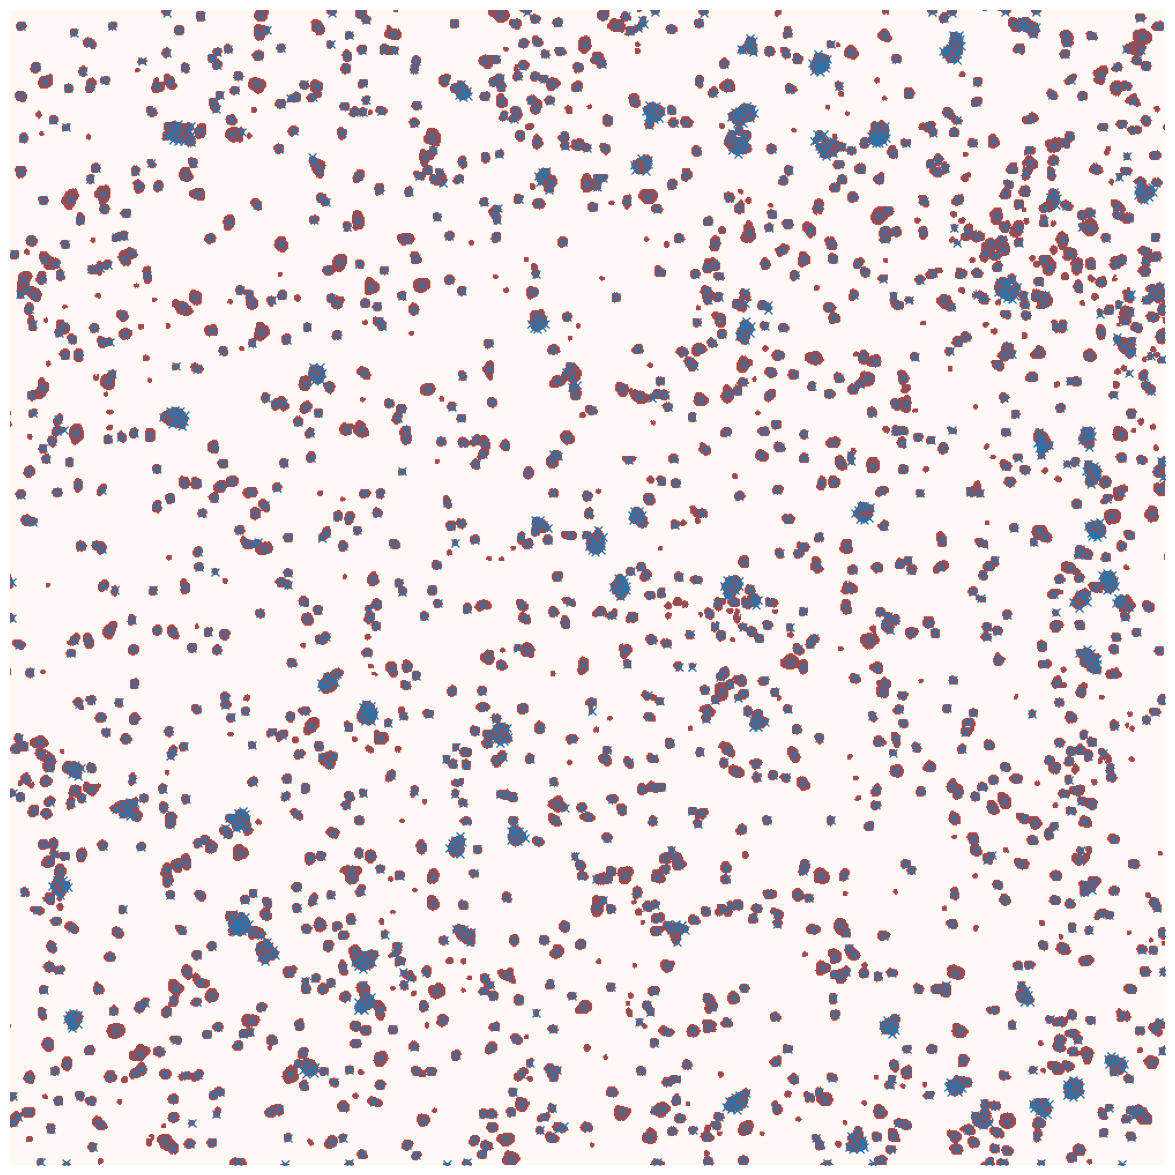

In [117]:
fig, ax = plt.subplots(1,1,figsize=[15,15])
ax.set_axis_off()
frame = label_tcell[FRAME,:,:].T
ax.imshow(exposure.rescale_intensity(frame, in_range=(0,1),out_range=(0,255)),cmap='Reds',alpha=0.7)
ax.plot(tracks_df[tracks_df.t==FRAME].y,tracks_df[tracks_df.t==FRAME].x,"x",label="T Cells")

Ultrack reassigns the label ids, we need to remap back to the original segmentaiton ids by position matching

In [121]:
from sklearn.neighbors import KDTree

tcell_df = features["tcell"]

tcell_t_df = tcell_df[tcell_df["frame"]==0]
tracks_t_df = tracks_df[tracks_df["t"]==0]
points_tcell = tcell_t_df[["y","x"]].values
points_ultrack = tracks_t_df[["x","y"]].values

# build KD-Tree for each point in ultrack df
kdtree_ultrack = KDTree(points_ultrack)

# query closest point for each point in t cell df
dist, indices = kdtree_ultrack.query(points_tcell,k=1)

dist = [d[0] for d in dist]
indices = [i[0] for i in indices]

remapped_track_ids = pd.DataFrame(tracks_t_df[["track_id","id"]].iloc[indices])
remapped_track_ids["dist_from_ultrack"] = dist

tcell_t_df.reset_index(drop=True,inplace=True)
remapped_track_ids.reset_index(drop=True,inplace=True)
tcell_t_df_remapped = pd.concat([tcell_t_df,remapped_track_ids],axis=1)

tcell_t_df_remapped

label           y           x  bbox_xstart  bbox_ystart  bbox_xsize  \
0         1  104.401084  146.029810          133           96          26   
1         2   32.806180  816.480337          806           19          19   
2         3  562.640580  934.205797          923          552          22   
3         4  702.398256  199.034884          186          692          25   
4         5   90.112760  633.952522          622           81          24   
...     ...         ...         ...          ...          ...         ...   
1882   1883  473.000000  999.000000          999          471           1   
1883   1884  348.500000    0.000000            0          347           1   
1884   1885    0.000000  843.500000          842            0           4   
1885   1886  879.000000    0.000000            0          878           1   
1886   1887    0.000000  139.000000          139            0           1   

      bbox_ysize           i           j  bbox_istart  ...           sd  \
0             19  146.029810  104.401084        133.0  ...  1708.249163   
1             27  816.480337   32.806180        806.0  ...   868.713254   
2             23  934.205797  562.640580        923.0  ...  2105.124412   
3             23  199.034884  702.398256        186.0  ...   962.565528   
4             19  633.952522   90.112760        622.0  ...  4960.360598   
...          ...         ...         ...          ...  ...          ...   
1882           5  999.000000  473.000000        999.0  ...     5.856620   
1883           4    0.000000  348.500000          0.0  ...     4.112988   
1884           1  843.500000    0.000000        842.0  ...    10.908712   
1885           3    0.000000  879.000000          0.0  ...     4.509250   
1886           1  139.000000    0.000000        139.0  ...     0.000000   

      frame  channel  alive  contact         contacting cell labels  \
0         0    tcell    NaN     True              [596, 1399, 1552]   
1         0    tcell    NaN     True               [77, 1357, 1854]   
2         0    tcell    NaN     True               [179, 658, 1616]   
3         0    tcell    NaN     True                           [40]   
4         0    tcell    NaN     True  [688, 1424, 1495, 2321, 2389]   
...     ...      ...    ...      ...                            ...   
1882      0    tcell    NaN    False                             []   
1883      0    tcell    NaN    False                             []   
1884      0    tcell    NaN    False                             []   
1885      0    tcell    NaN     True                          [130]   
1886      0    tcell    NaN    False                             []   

      closest cell dist  track_id       id  dist_from_ultrack  
0             11.013625      7978  1001365           3.105938  
1              0.543120     14529  1009079           2.853891  
2             13.378088     16021  1010790           3.269171  
3             13.643036      8756  1002062           3.813600  
4              6.275923     12756  1007023           2.113995  
...                 ...       ...      ...                ...  
1882          23.696102     16728  1011605          24.758837  
1883          13.764159      7008  1000223          24.418231  
1884          21.510960     15040  1009657           9.552487  
1885          10.334577      7077  1000376          34.000000  
1886          13.966279      8017  1001412           2.000000  

[1887 rows x 33 columns]

Save the remapped tracks dataframe

In [ ]:
# save tracks
tcell_t_df_remapped.to_csv("/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/Tcell_tracks/tracks/tcell_tracks_t={}.csv".format(FRAME))